In [18]:
# setting up all of the packages
!pip install -q optuna

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import optuna
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from utils import * 
from sklearn.metrics import mean_squared_error, r2_score
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

# raster and dataframe handling packages
import rasterio
import rioxarray as rio

# stats packages
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# print(os.getcwd())
# custom functions from class LEAP env.
from utils import * 

# plotting parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparing our predictor and predictand data
predictor: (X, TerraClim climate variables), predictant: (Y, MODIS LAI) data

In [19]:
# establish path and open our merged and masked climate and LAI data as an array
# path = "/home/jovyan/large_files/climLai_masked_v3.nc"
path = "/home/jovyan/large_files/climLai_masked_anom.nc"
ds_combined = xr.open_dataset(path)

In [20]:
# Count NaNs per variable, these should all match!
for var in ds_combined.data_vars:
    print(var, ds_combined[var].isnull().sum().item())

tmmx 598044
tmmn 598044
pr 598044
pdsi 598044
def 598044
vpd 598044
soil 598044
lai 598044


<xarray.Dataset> Size: 77MB
Dimensions:      (time: 228, lat: 71, lon: 74)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 284B -9.825 -9.875 -9.925 ... -13.28 -13.33
  * lon          (lon) float32 296B -72.38 -72.32 -72.28 ... -68.78 -68.72
    spatial_ref  (time) int64 2kB ...
    month        (time) int64 2kB ...
Data variables:
    tmmx         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    tmmn         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pr           (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    pdsi         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    def          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    vpd          (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    soil         (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan
    lai          (time, lat, lon) flo

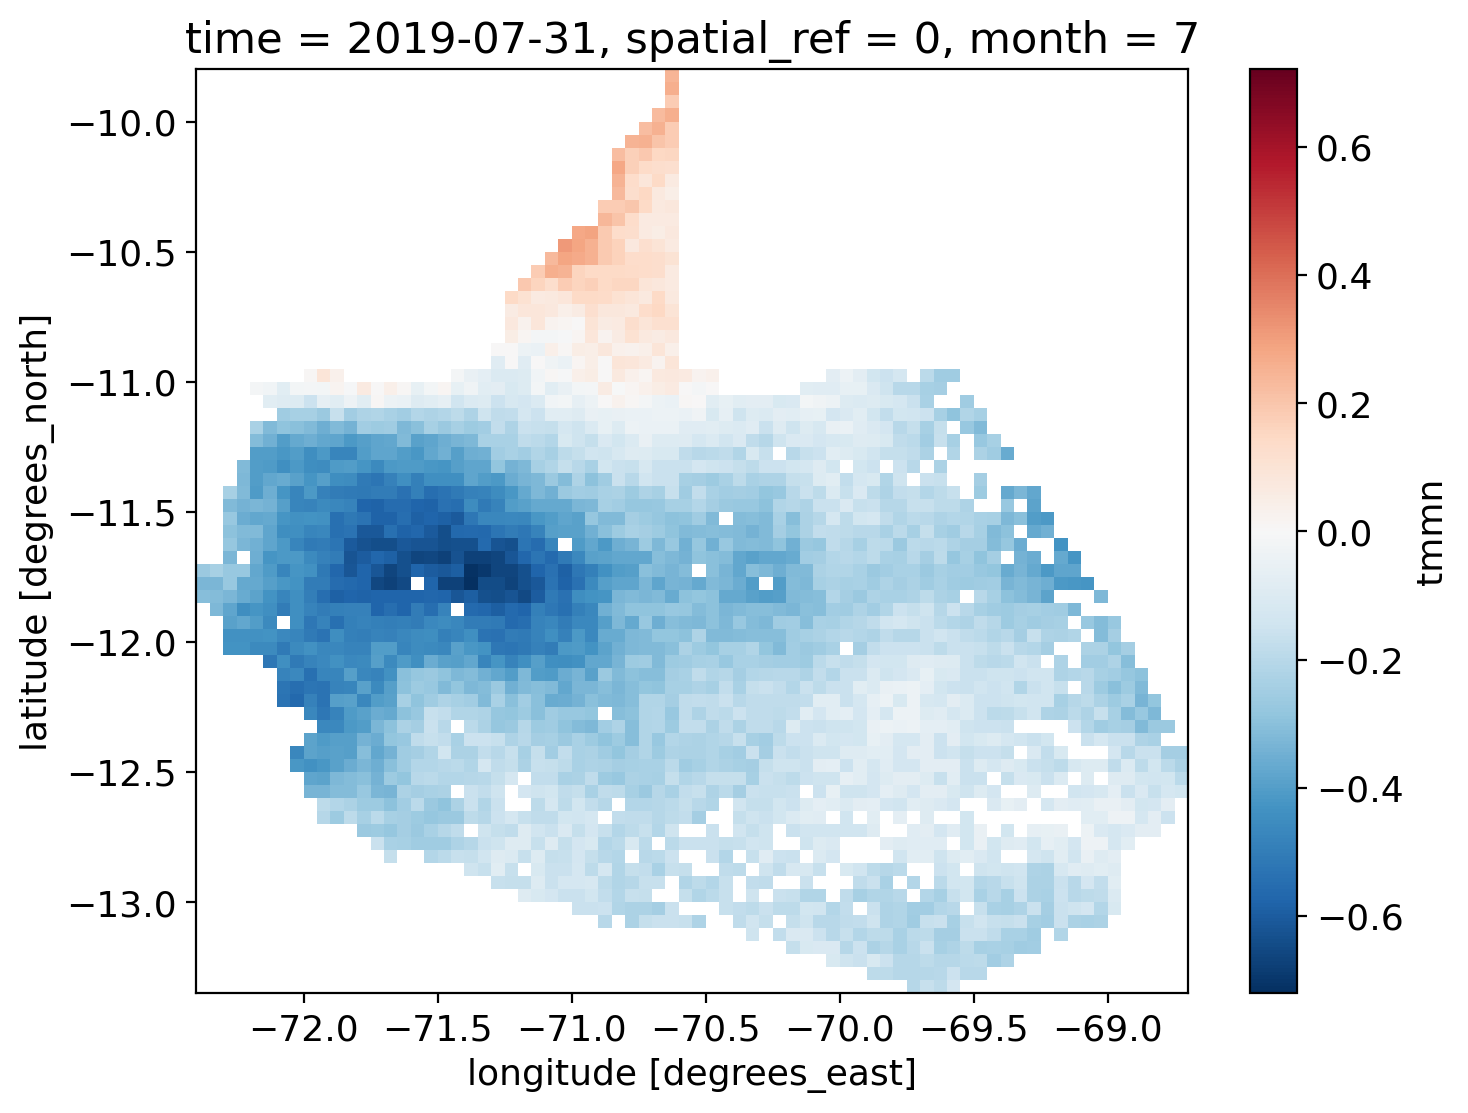

In [21]:
# take a look and map at the ds_combined dataset, this should only cover the political extent of Madre de Dios
print(ds_combined)
ds_combined.tmmn.isel(time=210).plot(figsize=(8,6))

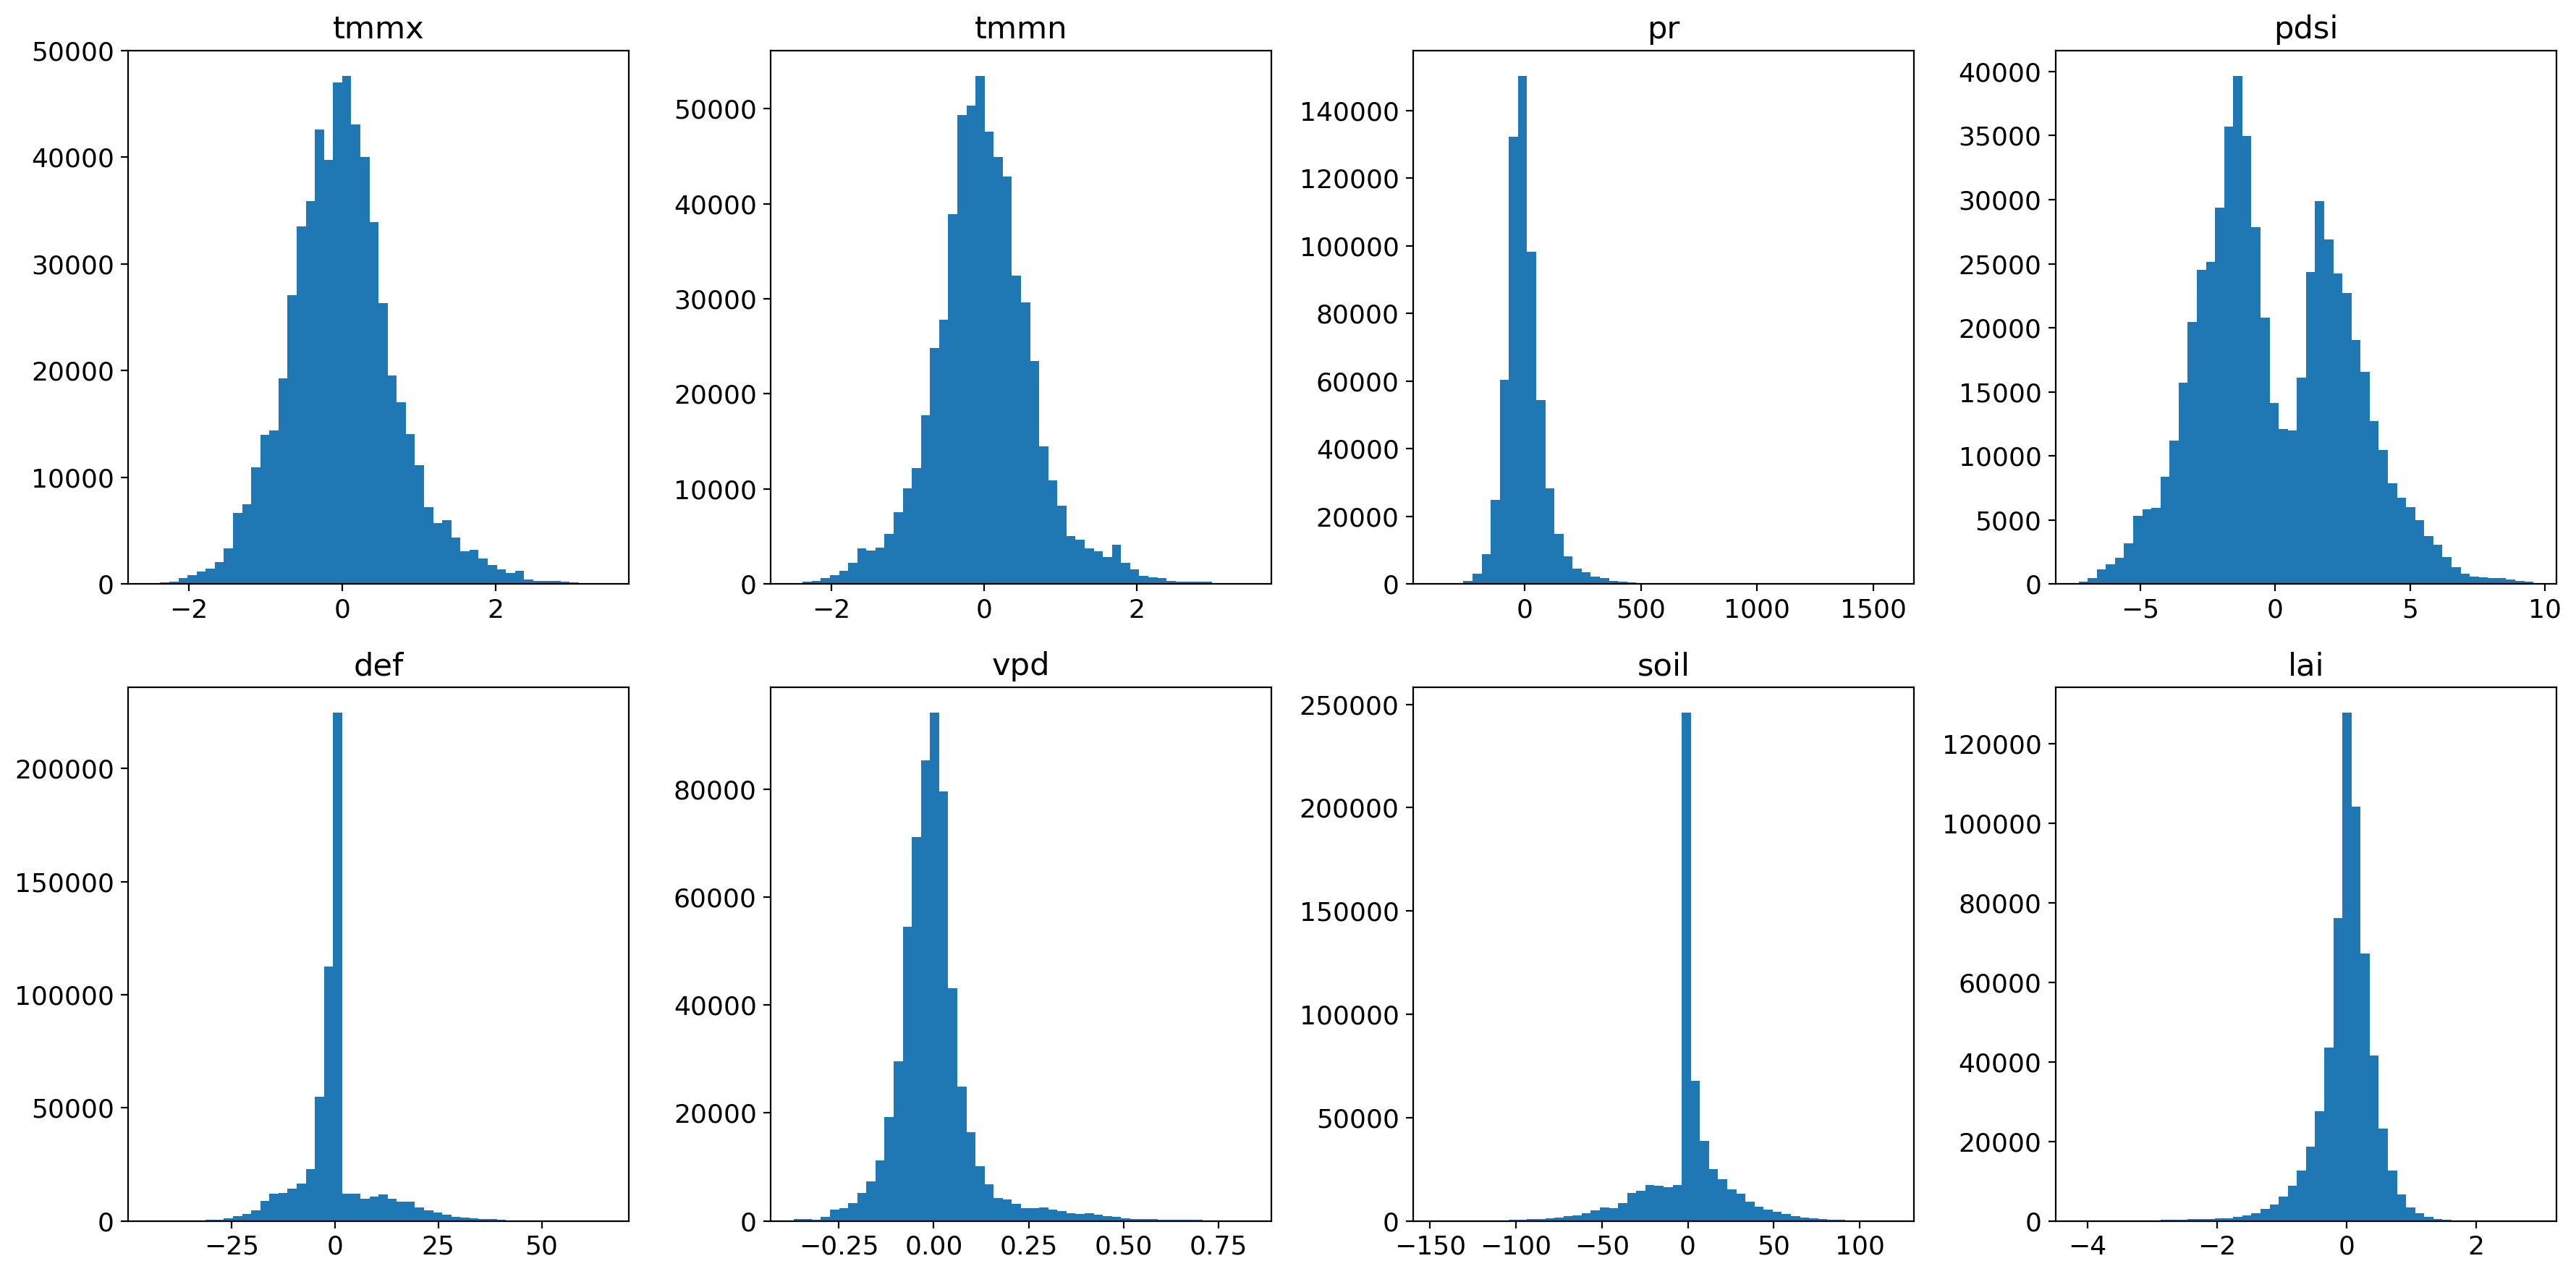

In [22]:
ds = ds_combined   # your dataset

vars_to_plot = ["tmmx","tmmn","pr","pdsi","def","vpd","soil","lai"]

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.ravel()

for ax, var in zip(axes, vars_to_plot):
    data = ds[var].values.flatten()
    data = data[~np.isnan(data)]
    ax.hist(data, bins=50)
    ax.set_title(var)

plt.tight_layout()
plt.show()

In [23]:
# the data array has 3 dimensions (time, lat, lon). Stack the coordinate values to go from 3d to 2d.
ds_stacked = ds_combined.stack(stacked=("lat", "lon"))

In [24]:
# convert to data frame for later processing. Time, lat, lon become indexes.
df_combined = ds_stacked.to_dataframe().dropna()
print(df_combined)

                                      tmmx      tmmn          pr      pdsi  \
time       lat        lon                                                    
2002-01-31 -9.825002  -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002  -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001  -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001  -70.674995  0.678947  0.642105  108.000000  6.787368   
                      -70.625000  0.626316  0.621053  110.473684  6.945263   
...                                    ...       ...         ...       ...   
2020-12-31 -13.275002 -69.474998  0.763158  0.589474  104.684211 -2.172632   
           -13.325002 -69.724998  0.784211  0.642105  103.894737 -0.917368   
                      -69.674995  0.800000  0.626316  104.526316 -0.950000   
                      -69.625000  0.763158  0.657895  106.368421 -1.386316   
                      -69.574997  0.800000  0.610526  107.631579

In [25]:
# from dataframe generate the x_df (ONLY climate predictor variables, drop the lai column)
x_df = df_combined.drop(columns=["lai","spatial_ref"])

# look at x_df, make sure it looks ok!
x_df.head()

tmmx      tmmn          pr      pdsi  \
time       lat       lon                                                    
2002-01-31 -9.825002 -70.625000  0.710526  0.610526  127.473684  6.951053   
           -9.875002 -70.625000  0.663158  0.657895  118.894737  7.005263   
           -9.925001 -70.625000  0.642105  0.626316  114.736842  6.954737   
           -9.975001 -70.674995  0.678947  0.642105  108.000000  6.787368   
                     -70.625000  0.626316  0.621053  110.473684  6.945263   

                                 def       vpd          soil  month  
time       lat       lon                                             
2002-01-31 -9.825002 -70.625000  0.0  0.092632  5.684342e-14      1  
           -9.875002 -70.625000  0.0  0.092632 -5.684342e-14      1  
           -9.925001 -70.625000  0.0  0.090526  0.000000e+00      1  
           -9.975001 -70.674995  0.0  0.099474 -5.684342e-14      1  
                     -70.625000  0.0  0.096842  5.684342e-14      1

In [26]:
# from dataframe generate y_df (ONLY lai)
y_df = df_combined.drop(columns=["spatial_ref",
                                 "tmmx",
                                 "tmmn",
                                 "pr",
                                 "pdsi",
                                 "def",
                                 "vpd",
                                 "soil"])

# look at y_df, make sure it looks ok!
y_df.head()

lai  month
time       lat       lon                        
2002-01-31 -9.825002 -70.625000  0.657735      1
           -9.875002 -70.625000  0.193407      1
           -9.925001 -70.625000  0.175278      1
           -9.975001 -70.674995  0.773132      1
                     -70.625000  0.000997      1

## Split our data into training, validation and testing and normalize
Look at the entire time sequence of our data: 19 years, 12 months per year
(19yrs x 12months) = 228 time steps

We want the last two years to be our testing dataset: 2019 and 2020
Therefore, the first 17 tears are our training and validation data
Of this, 80% must be training (14 years), 20% must be validation (3 years)

So the final break-down is:
Training: 2002-2015 (14yrs x 12months = 168 ts)
Validation: 2016-2018 (3yrs x 12months = 36 ts)
Testing: 2019-2020 (2yrs x 12months = 24 ts)

In [30]:
# CHANGED

# # 1 - set hyperparameters
# n_neuron       = 64
# num_layers     = 1
# activation     = 'ReLU'
# num_epochs     = 30
# learning_rate  = 0.00001
# minibatch_size = 64 #CHECK
# model_version  = "6_3"
# lookback       = 9

train_yr_start = 2003
test_yr_start = 2016
test_yr_end = 2020

In [31]:
# look at the entire time sequence of our data
first_time = x_df.index.get_level_values("time")[0]
last_time  = x_df.index.get_level_values("time")[-1]

print('time 0 =', first_time)
print('time last =', last_time)

time 0 = 2002-01-31 00:00:00
time last = 2020-12-31 00:00:00


In [32]:
# -----------------------------
# 1. Define time boundaries
# -----------------------------
train_start = f"{train_yr_start}-01-31"
test_start  = f"{test_yr_start}-01-31"
test_end    = f"{test_yr_end+1}-01-31"   # exclusive

times = x_df.index.get_level_values("time")

# -----------------------------
# 2. Split data by time
# -----------------------------
x_df_train = x_df.loc[times < test_start]
y_df_train = y_df.loc[times < test_start]

x_df_test  = x_df.loc[(times >= test_start) & (times < test_end)]
y_df_test  = y_df.loc[(times >= test_start) & (times < test_end)]

# -----------------------------
# 3. Remove noisy early year (2002)
# -----------------------------
x_df_train = x_df_train.loc[x_df_train.index.get_level_values("time") >= train_start]
y_df_train = y_df_train.loc[y_df_train.index.get_level_values("time") >= train_start]

# -----------------------------
# 4. Min–max normalize (train → test)
# -----------------------------
feature_cols = ["tmmx", "tmmn", "pr", "pdsi", "def", "vpd", "soil"]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x_df_train[feature_cols])

x_df_train[feature_cols] = scaler.transform(x_df_train[feature_cols])
x_df_test[feature_cols]  = scaler.transform(x_df_test[feature_cols])

# -----------------------------
# 5. Sanity checks
# -----------------------------
print("train:", x_df_train.index.get_level_values("time")[0],
      "→", x_df_train.index.get_level_values("time")[-1])

print("test :", x_df_test.index.get_level_values("time")[0],
      "→", x_df_test.index.get_level_values("time")[-1])


train: 2003-01-31 00:00:00 → 2015-12-31 00:00:00
test : 2016-01-31 00:00:00 → 2020-12-31 00:00:00


/tmp/ipykernel_2043/2617549613.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df_test[feature_cols]  = scaler.transform(x_df_test[feature_cols])


In [33]:
feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil"]

# let's check the normalizaton
# look at some summary statistics to check the normalization
train_stats = x_df_train[feature_cols].agg(['mean','std']).T
test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# let's check our standardization
print("Training data\n", train_stats)
print("Testing data\n", test_stats)

Training data
           mean       std
tmmx  0.473353  0.122076
tmmn  0.534577  0.138640
pr    0.191904  0.047426
pdsi  0.470435  0.189608
def   0.407784  0.088270
vpd   0.479761  0.080948
soil  0.557785  0.098036
Testing data
           mean       std
tmmx  0.611239  0.151032
tmmn  0.594981  0.162980
pr    0.195924  0.034484
pdsi  0.501233  0.125154
def   0.394237  0.068665
vpd   0.567969  0.244986
soil  0.570664  0.093563


In [62]:
# test to make sure the splits worked:
print('shape x_df_train', x_df_train.shape)
# print('shape x_df_valid', x_df_valid.shape)
print('shape x_df_test', x_df_test_all.shape)

print('shape y_df_train', y_df_train.shape)
# print('shape y_df_valid', y_df_valid.shape)
print('shape y_df_test', y_df_test_all.shape)

shape x_df_train (410436, 8)
shape x_df_test (157860, 8)
shape y_df_train (410436, 2)
shape y_df_test (157860, 2)


In [63]:
# # look at some summary statistics to check the normalization
# train_stats = x_df_train[feature_cols].agg(['mean','std']).T
# # valid_stats = x_df_valid[feature_cols].agg(['mean','std']).T
# test_stats = x_df_test[feature_cols].agg(['mean','std']).T

# # let's check our standardization
# print("Training data\n", train_stats)
# # print("Validation data\n", valid_stats)
# print("Testing data\n", test_stats)

Training data
           mean       std
tmmx  0.473353  0.122076
tmmn  0.534577  0.138640
pr    0.191904  0.047426
pdsi  0.470435  0.189608
def   0.407784  0.088270
vpd   0.479761  0.080948
soil  0.557785  0.098036
Testing data
           mean       std
tmmx  0.611239  0.151032
tmmn  0.594981  0.162980
pr    0.195924  0.034484
pdsi  0.501233  0.125154
def   0.394237  0.068665
vpd   0.567969  0.244986
soil  0.570664  0.093563


In [64]:
print(x_df_train)
print(x_df_test)
print(y_df_train)
print(y_df_test)

                                      tmmx      tmmn        pr      pdsi  \
time       lat        lon                                                  
2003-01-31 -9.825002  -70.625000  0.633333  0.662413  0.233125  0.802811   
           -9.875002  -70.625000  0.603226  0.650812  0.234362  0.816007   
           -9.925001  -70.625000  0.598925  0.643852  0.234793  0.815971   
           -9.975001  -70.674995  0.606452  0.647332  0.233394  0.816829   
                      -70.625000  0.595699  0.620650  0.235169  0.820763   
...                                    ...       ...       ...       ...   
2015-12-31 -13.275002 -69.474998  0.970968  0.393271  0.115716  0.642206   
           -13.325002 -69.724998  0.954839  0.382831  0.112757  0.634410   
                      -69.674995  0.958065  0.379350  0.113080  0.635590   
                      -69.625000  0.970968  0.386311  0.114021  0.637199   
                      -69.574997  0.958065  0.397912  0.114156  0.639023   

           

In [65]:
def create_lags(df, feature_cols, n_lags):
    """
    df: DataFrame with multi-index (time, lat, lon)
    feature_cols: list of columns to create lags for
    n_lags: number of lag steps
    """
    lagged_dfs = []

    # Group by spatial location
    for (lat, lon), group in df.groupby(level=[1, 2]):
        group_lags = group[feature_cols].copy()
        for col in feature_cols:
            for lag in range(1, n_lags+1):
                group_lags[f"{col}_lag{lag}"] = group[col].shift(lag)
        lagged_dfs.append(group_lags)

    # Concatenate all
    lagged_df = pd.concat(lagged_dfs)
    return lagged_df

In [66]:
# feature_cols = ["tmmx","tmmn","pr","pdsi","def","vpd","soil","month"]
feat = 'tmmx'
train_lags = create_lags(x_df_train, feature_cols = [feat], n_lags=12)
test_lags = create_lags(x_df_test, feature_cols = [feat], n_lags=12)

In [67]:
train_lags_clean = train_lags.dropna()
test_lags_clean = test_lags.dropna()
y_train_lags_clean = y_df_train.loc[train_lags_clean.index]["lai"]
y_test_lags_clean = y_df_test.loc[test_lags_clean.index]["lai"]

print(train_lags_clean)
print(len(train_lags_clean))
print(len(y_train_lags_clean))
print(y_test_lags_clean)

test_index = test_lags_clean.index
print(test_index)

                                      tmmx  tmmx_lag1  tmmx_lag2  tmmx_lag3  \
time       lat        lon                                                     
2004-01-31 -13.325002 -69.724998  0.453763   0.566667   0.566667   0.507527   
2004-02-29 -13.325002 -69.724998  0.540860   0.453763   0.566667   0.566667   
2004-03-31 -13.325002 -69.724998  0.629032   0.540860   0.453763   0.566667   
2004-04-30 -13.325002 -69.724998  0.521505   0.629032   0.540860   0.453763   
2004-05-31 -13.325002 -69.724998  0.491398   0.521505   0.629032   0.540860   
...                                    ...        ...        ...        ...   
2015-08-31 -9.825002  -70.625000  0.684946   0.508602   0.625806   0.568817   
2015-09-30 -9.825002  -70.625000  0.656989   0.684946   0.508602   0.625806   
2015-10-31 -9.825002  -70.625000  0.696774   0.656989   0.684946   0.508602   
2015-11-30 -9.825002  -70.625000  0.670968   0.696774   0.656989   0.684946   
2015-12-31 -9.825002  -70.625000  0.574194   0.67096

In [34]:
n_estimators      = 100    # Number of trees in random forest
min_samples_split = 10     # Minimum number of samples required to split a node
min_samples_leaf  = 4      # Minimum number of samples required at each leaf node
max_features      = None   # Number of features to consider at every split: 'sqrt', 'log2', or None.
                           # None: max_features=n_feature
max_depth         = None     # Maximum number of levels in tree
bootstrap         = True   # Method of selecting samples for training each tree

reg0 = RandomForestRegressor(n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             min_samples_leaf=min_samples_leaf,
                             max_features=max_features,
                             max_depth=max_depth,
                             bootstrap=bootstrap)

rf_tas = reg0.fit(train_lags_clean,y_train_lags_clean)

In [35]:
# reg0.feature_importances_

importances = pd.Series(
    reg0.feature_importances_,
    index=train_lags_clean.columns
).sort_values(ascending=False)

print(importances)

print('something')

tmmx_lag6     0.118555
tmmx_lag5     0.086857
tmmx_lag7     0.086482
tmmx_lag3     0.086459
tmmx_lag8     0.084788
tmmx_lag4     0.082105
tmmx_lag11    0.075446
tmmx_lag9     0.068637
tmmx_lag2     0.065882
tmmx          0.065360
tmmx_lag10    0.063348
tmmx_lag1     0.059757
tmmx_lag12    0.056324
dtype: float64
something


In [36]:
# y_test_pre = rf_tas.predict(X_test)
# y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

# y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
#                                'latitude': X_test_xr.latitude.values, 
#                                'longitude': X_test_xr.longitude.values},
#                         data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

In [37]:
y_pred_test = reg0.predict(test_lags_clean)
y_pred_test

array([ 0.10418868, -0.01047098, -0.02207446, ..., -0.80143473,
       -0.41700103,  0.19833696], shape=(126288,))

In [38]:
rmse = np.sqrt(mean_squared_error(y_test_lags_clean, y_pred_test))
r2   = r2_score(y_test_lags_clean, y_pred_test)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 0.43713535393858216
R²: -0.43704066465526714


(126288,)
(126288,)
time        lat         lon       
2017-01-31  -13.325002  -69.724998    0.554704
2017-02-28  -13.325002  -69.724998    0.002483
2017-03-31  -13.325002  -69.724998   -0.779463
2017-04-30  -13.325002  -69.724998   -0.042568
2017-05-31  -13.325002  -69.724998    0.193532
                                        ...   
2020-08-31  -9.825002   -70.625000    0.126097
2020-09-30  -9.825002   -70.625000    0.071400
2020-10-31  -9.825002   -70.625000    0.262394
2020-11-30  -9.825002   -70.625000    0.227440
2020-12-31  -9.825002   -70.625000    0.238278
Name: lai, Length: 126288, dtype: float64
[ 0.10418868 -0.01047098 -0.02207446 ... -0.80143473 -0.41700103
  0.19833696]
             time        lat        lon      true      pred
0      2017-01-31 -13.325002 -69.724998  0.554704  0.104189
1      2017-02-28 -13.325002 -69.724998  0.002483 -0.010471
2      2017-03-31 -13.325002 -69.724998 -0.779463 -0.022074
3      2017-04-30 -13.325002 -69.724998 -0.042568  0.256459
4      

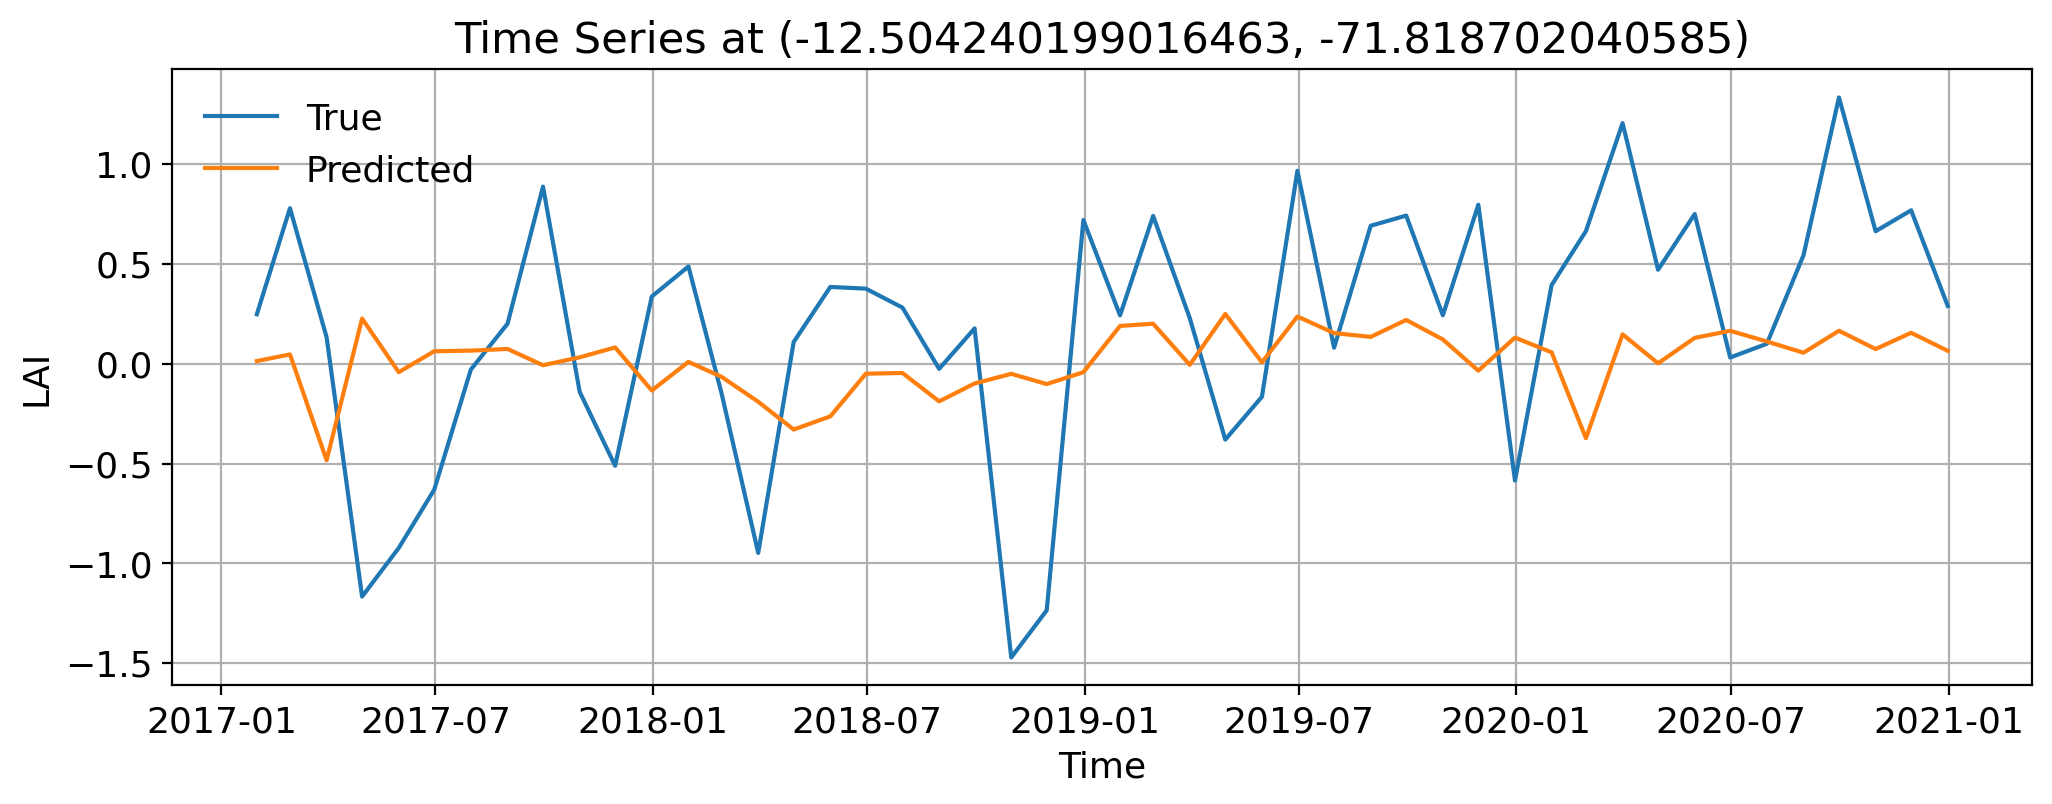

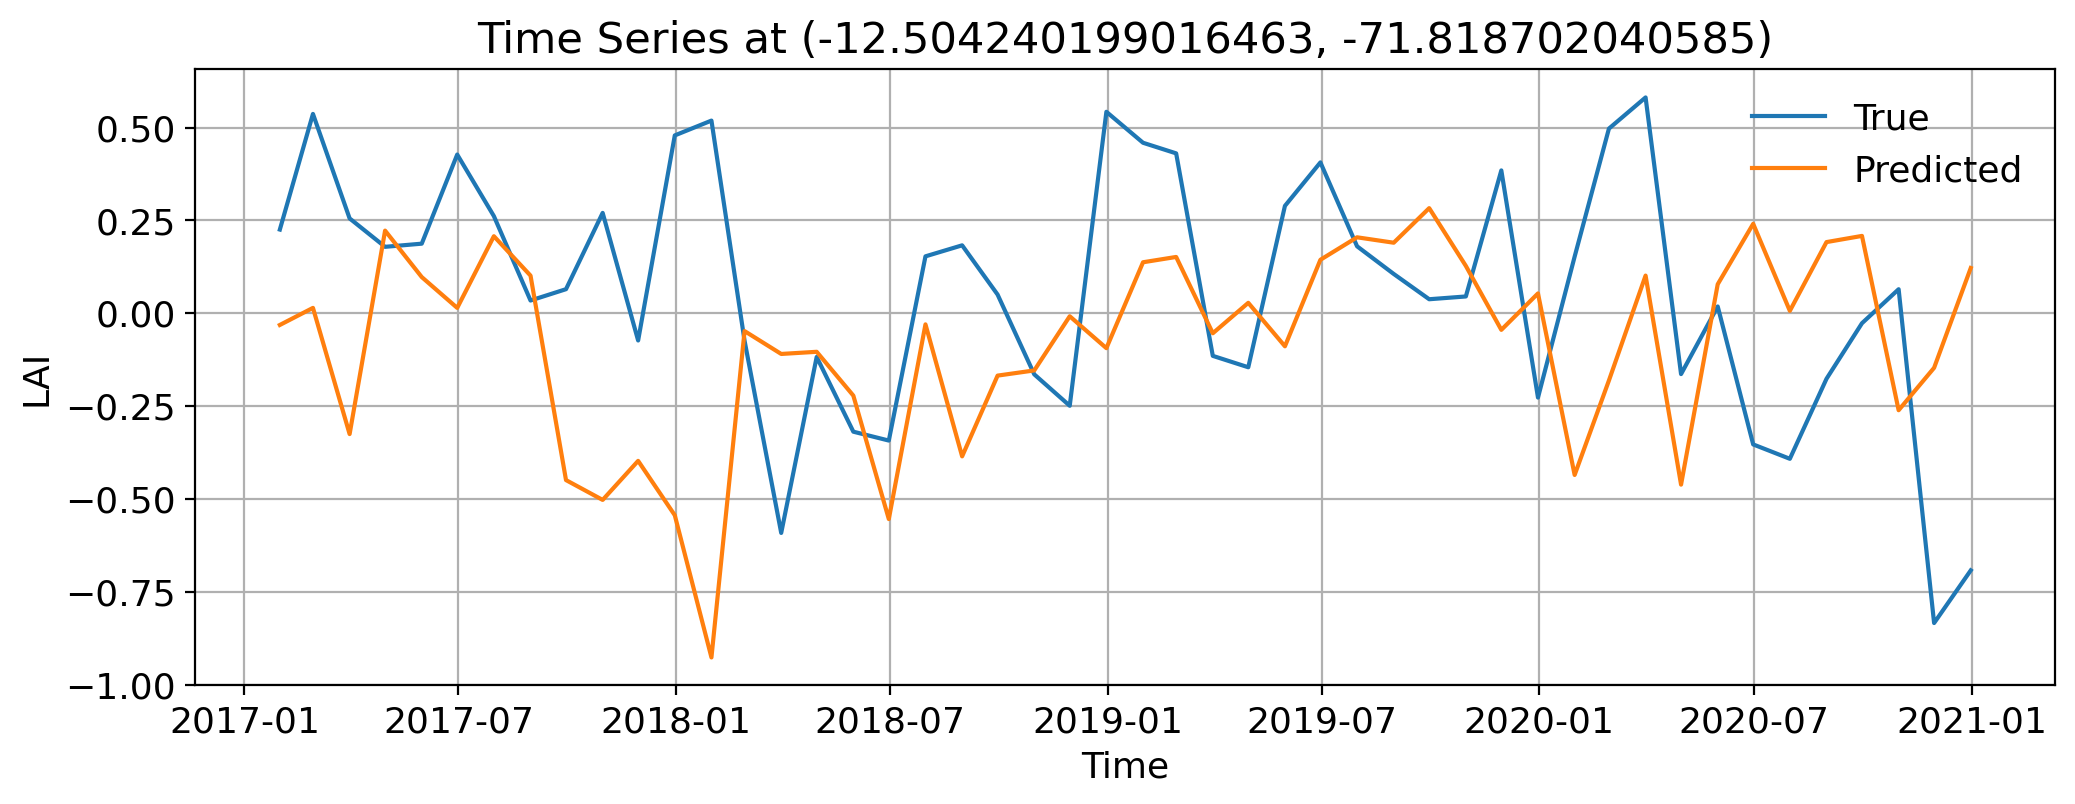

In [46]:
print(y_test_lags_clean.values.shape)
print(y_pred_test.shape)
print(y_test_lags_clean)
print(y_pred_test)

pred_df = pd.DataFrame({
    "time": test_index.get_level_values("time"),
    "lat":  test_index.get_level_values("lat"),
    "lon":  test_index.get_level_values("lon"),
    "true": y_test_lags_clean.values,
    "pred": y_pred_test
})

print(pred_df)

sw_lat, sw_lon = -12.504240199016463, -71.818702040585     # southwest corner  
ct_lat, ct_lon = -11.730855612666398, -70.79697352496      # central

lat0 = sw_lat
lon0 = sw_lon

def nearest_pixel(df, target_lat, target_lon):
    d = np.sqrt((df.lat - target_lat)**2 + (df.lon - target_lon)**2)
    idx = d.idxmin()
    return df.loc[idx, ['lat','lon']]

print("Nearest to SW:", nearest_pixel(pred_df, sw_lat, sw_lon))
print("Nearest to CT:", nearest_pixel(pred_df, ct_lat, ct_lon))

# Get nearest actual coords
sw_actual = nearest_pixel(pred_df, sw_lat, sw_lon)
ct_actual = nearest_pixel(pred_df, ct_lat, ct_lon)

pix_sw = pred_df[(pred_df.lat == sw_actual.lat) & (pred_df.lon == sw_actual.lon)]
pix_ct = pred_df[(pred_df.lat == ct_actual.lat) & (pred_df.lon == ct_actual.lon)]

# pixel_df = pred_df[(pred_df.lat == lat0) & (pred_df.lon == lon0)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(pix_sw.time, pix_sw.true, label="True")
plt.plot(pix_sw.time, pix_sw.pred, label="Predicted")
plt.title(f"Time Series at ({lat0}, {lon0})")
plt.xlabel("Time")
plt.ylabel("LAI")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,4))
plt.plot(pix_ct.time, pix_ct.true, label="True")
plt.plot(pix_ct.time, pix_ct.pred, label="Predicted")
plt.title(f"Time Series at ({lat0}, {lon0})")
plt.xlabel("Time")
plt.ylabel("LAI")
plt.legend()
plt.grid(True)
plt.show()


mean_ts = pred_df.groupby("time")[["pred","true"]].mean()

plt.figure(figsize=(12,4))
plt.plot(mean_ts.index, mean_ts["true"], label="Mean True")
plt.plot(mean_ts.index, mean_ts["pred"], label="Mean Pred")
plt.legend()
plt.title("Mean LAI Over All Pixels")
plt.show()

In [48]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]

# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,55, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12,16]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['sqrt', 'log2', None], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, None], 'min_samples_split': [5, 10, 15, 25], 'min_samples_leaf': [4, 8, 12, 16], 'bootstrap': [True, False]}


In [49]:
reg0 = RandomForestRegressor(random_state=0)
# perform cross validation
rf_random0 = RandomizedSearchCV(estimator = reg0, param_distributions = random_grid, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)
rf_tas = rf_random0.fit(train_lags_clean,y_train_lags_clean)

print("The best hyperparameters: \n",rf_tas.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 8.4min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=300; total time= 4.9min


/srv/conda/envs/notebook/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 7.7min
[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 8.9min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=25, n_estimators=250; total time= 3.6min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=25, n_estimators=150; total time= 8.3min
[CV] END bootstrap=True, max_depth=35, max_features=None, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time= 7.9min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=8, min_samples_split=25, n_estimators=250; total time= 3.8min
[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=200; total time= 6.9min
The best hyperparameters: 
 {'n_es

In [54]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 300]),
        "max_depth": trial.suggest_categorical("max_depth", [10, 20, 30, 40, 50, None]),
        "min_samples_split": trial.suggest_categorical("min_samples_split", [5,10,15,25]),
        "min_samples_leaf": trial.suggest_categorical("min_samples_leaf",  [4,8,12,16]),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True]),
    }

    model = RandomForestRegressor(
        **params,
        random_state=0,
        n_jobs=-1
    )

    cv_scores = cross_val_score(
        model, train_lags_clean, y_train_lags_clean,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    return cv_scores.mean()  # Optuna maximizes objective

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=30, n_jobs=1)   # 50 trials usually beats 500 random grid runs

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-12-12 23:45:27,511] A new study created in memory with name: no-name-318065ae-9d1c-421c-8397-0ebd6069dd48
[I 2025-12-12 23:46:00,235] Trial 0 finished with value: -0.12190760918833189 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: -0.12190760918833189.
[I 2025-12-12 23:57:41,435] Trial 1 finished with value: -0.11104309172703826 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -0.11104309172703826.
[I 2025-12-13 00:03:51,937] Trial 2 finished with value: -0.1331626119624988 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 25, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: -0.11104309172703826.
[I 2025-12-13 00:07:12,560] Trial 3 finished with value: -0.10086

KeyboardInterrupt: 